# vertical slice

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from ipdb import set_trace as mybreak
import pyicon as pyic
import cartopy.crs as ccrs
import glob
import pickle
import maps_icon_smt_temp as smt
import datetime
from matplotlib.patches import Rectangle
import cfgrib
import xarray as xr
import pandas as pd
import gsw
import matplotlib.gridspec as gridspec
from icon_smt_levels import dzw, dzt, depthc, depthi

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots


### load data

In [2]:
path_data    = '/work/mh0033/u241317/smt/vh/pp_calc_div_h.nc'
ddiv = xr.open_dataset(path_data)
ddiv

<xarray.Dataset>
Dimensions:  (cc: 59799625, depthc: 112)
Coordinates:
  * depthc   (depthc) float32 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: cc
Data variables:
    w        (depthc, cc) float32 ...

In [15]:
cc        = int(59799625)
w0 = np.zeros([ cc], dtype='f4')

In [16]:
a = w0 - ddiv.w.isel(depthc=1)

In [17]:
a

<xarray.DataArray 'w' (cc: 59799625)>
array([-1.18381817e-04, -1.13630216e-04, -6.97808355e-05, ...,
       -3.82791086e-06,  1.79143797e-06,  3.05426482e-07], dtype=float32)
Coordinates:
    depthc   float32 6.5
Dimensions without coordinates: cc

In [34]:
path_data    = '/work/mh0033/u241317/smt_w/pp_ncalc_w_period_2010-03-20T19:00:00.nc'
ds = xr.open_dataset(path_data)
ds

<xarray.Dataset>
Dimensions:  (cc: 59799625, depthi: 113)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: cc
Data variables:
    w        (depthi, cc) float32 ...

In [6]:
path_data    = '/work/mh0033/u241317/smt/db/pp_calc_b_period_2010-03-15T23:00:00.nc'
db = xr.open_dataset(path_data)
#b  = db.b.isel(depthi=iz)

In [179]:
path_data    = '/work/mh0033/u241317/smt/results/pp_calc_w_n.nc'
#path_data    = '/work/mh0033/u241317/smt/vh/pp_calc_v_h.nc'
#path_data    = '/work/mh0033/u241317/smt_w/pp_calc_w_period_2010-03-15T23:00:00.nc'
dw = xr.open_dataset(path_data)
#w = dw.isel(depthi=iz).w
#dw = dw.rename({'vert_velocity': 'cc'}) # only necessary for corrupted dims

In [2]:
#path_data    = '/work/mh0033/u241317/smt/T/pp_calc_T_interp.nc'
path_data    = '/work/mh0033/u241317/smt/T/pp_calc_T_period_2010-03-15T23:00:00.nc'
dT = xr.open_dataset(path_data)
T = dT.T.rename({'temperature': 'cc'}) # only necessary for corrupted dims

### assign coords

In [83]:
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
f.close()

In [28]:
dw = dw.assign_coords(clon=("cc", clon),clat=("cc", clat))
#dw = dw.swap_dims(cc="clat")
dw #= dw.expand_dims("clon")

<xarray.Dataset>
Dimensions:  (cc: 59799625, depthi: 113)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
    clon     (cc) float64 -54.21 -54.22 -54.22 -54.21 ... -71.82 -71.8 -71.82
    clat     (cc) float64 36.49 36.5 36.49 36.49 ... 9.447 9.437 9.447 9.453
Dimensions without coordinates: cc
Data variables:
    w        (depthi, cc) float32 ...

In [29]:
abslat = np.abs(dw.clat-40)
abslon = np.abs(dw.clon+65)
c = np.maximum(abslon, abslat)
c

<xarray.DataArray 'clon' (cc: 59799625)>
array([10.78674932, 10.78423252, 10.783703  , ..., 30.56287114,
       30.55327635, 30.5470091 ])
Coordinates:
    clon     (cc) float64 -54.21 -54.22 -54.22 -54.21 ... -71.82 -71.8 -71.82
    clat     (cc) float64 36.49 36.5 36.49 36.49 ... 9.447 9.437 9.447 9.453
Dimensions without coordinates: cc

In [31]:
c.shape

(59799625,)

In [32]:
lon0, lat0 = -62.5, 41
ic = np.argmin( (clon-lon0)**2 + (clat-lat0)**2 ) 

In [45]:
lon_reg = [-75, -55]
lat_reg = [33, 43]
lon_regm = [-65, -60]
lat_regm = [39, 41.5]
lon_regs = [-64.8, -64.4]
lat_regs = [39.6, 39.8]
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'

In [31]:
A = ds.w #.isel(depthi=6)
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_regm, lat_reg=(lat_regm[0],lat_regm[0]+0.02))

MemoryError: Unable to allocate 25.2 GiB for an array with shape (113, 59799625) and data type float32

In [ ]:
toi.shape

In [ ]:
toi = np.array(toi)
print(toi.shape)
toi = toi.squeeze()

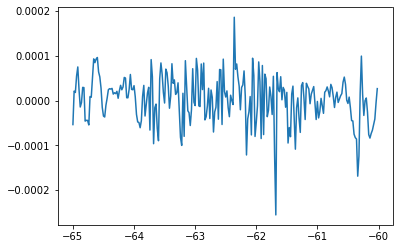

In [9]:
# new div calc
plt.plot(lon,toi[10])

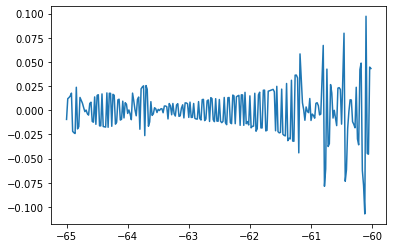

In [77]:
#positive
plt.plot(lon,toi[10])

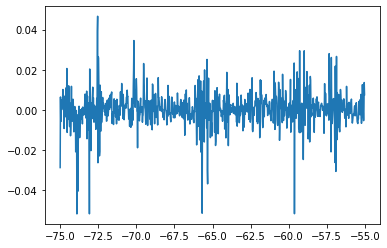

In [155]:
plt.plot(lon,toi[10])

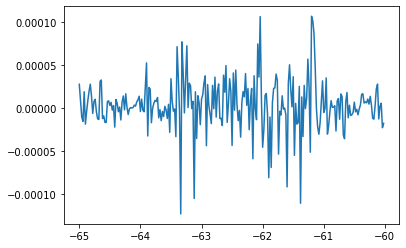

In [13]:
#DIVERGENCE
plt.plot(lon,toi[10])

<ipython-input-17-bb8954d29c80>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax0.pcolormesh(lon, depthc, toi)


(5500.0, 0.0)

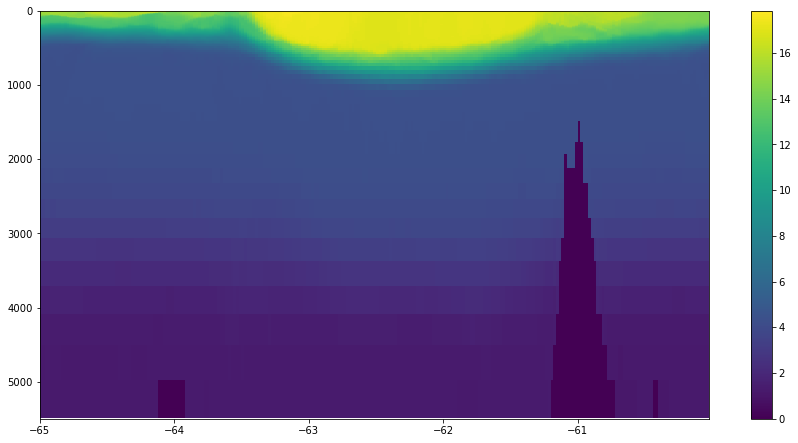

In [17]:
ylim=(5500,0)
#levels = np.array([-1e-5, 0, 1, 10, 100, 1000])
#cmap = plt.get_cmap('RdYlBu')
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
fig, ax0 = plt.subplots( figsize=(15,7.5))
im = ax0.pcolormesh(lon, depthc, toi)
fig.colorbar(im, ax=ax0)
#ax0.set_title('pcolormesh with levels')
ax0.set_ylim(ylim)

<ipython-input-68-2ae40c6a5564>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax0.pcolormesh(lon, depthi, toi)


(6000.0, 0.0)

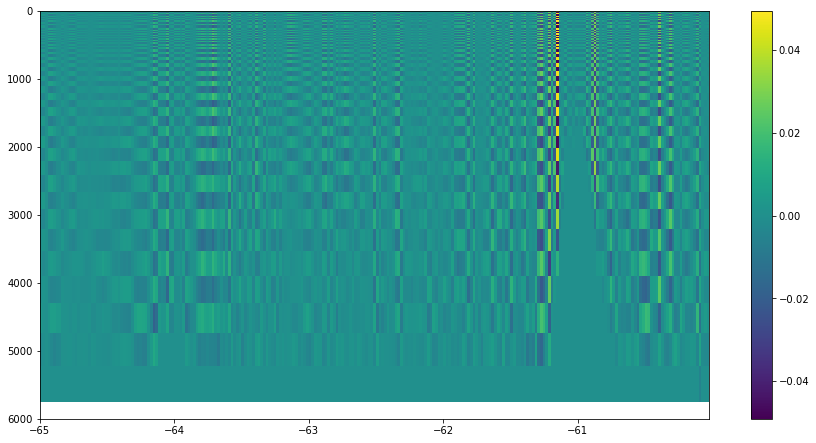

In [68]:
#negativ
ylim=(6000,0)
#levels = np.array([-1e-5, 0, 1, 10, 100, 1000])
#cmap = plt.get_cmap('RdYlBu')
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
fig, ax0 = plt.subplots( figsize=(15,7.5))
im = ax0.pcolormesh(lon, depthi, toi)
fig.colorbar(im, ax=ax0)
#ax0.set_title('pcolormesh with levels')
ax0.set_ylim(ylim)

<ipython-input-112-e7d158b5b167>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax0.pcolormesh(lon, depthi, toi, clim=0.075) #, cmap='seismic'


(6000.0, 0.0)

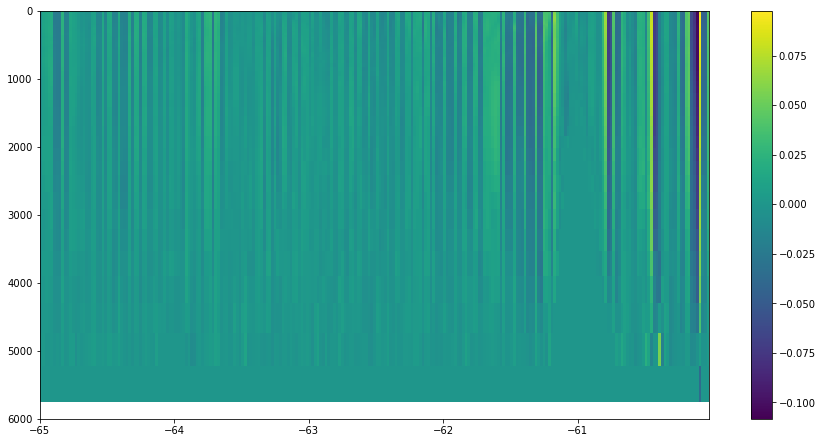

In [112]:
#positiv
ylim=(6000,0)
#levels = np.array([-1e-5, 0, 1, 10, 100, 1000])
#cmap = plt.get_cmap('RdYlBu')
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
fig, ax0 = plt.subplots( figsize=(15,7.5))
im = ax0.pcolormesh(lon, depthi, toi, clim=0.075) #, cmap='seismic'
fig.colorbar(im, ax=ax0)
#ax0.set_title('pcolormesh with levels')
ax0.set_ylim(ylim)

In [10]:
# div new calc
ylim=(6000,0)
fig, ax0 = plt.subplots( figsize=(15,7.5))
im = ax0.pcolormesh(lon, depthc, toi) #, cmap='seismic'
fig.colorbar(im, ax=ax0)
#ax0.set_title('pcolormesh with levels')
ax0.set_ylim(ylim)

<ipython-input-10-37ec952de15e>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax0.pcolormesh(lon, depthc, toi) #, cmap='seismic'


(6000.0, 0.0)

In [2]:
path_data    = '/scratch/u/u241317/calc/pp_calc_w_n.nc'
#path_data    = '/work/mh0033/u241317/smt/vh/pp_calc_v_h.nc'
#path_data    = '/work/mh0033/u241317/smt_w/pp_calc_w_period_2010-03-15T23:00:00.nc'
dw = xr.open_dataset(path_data)
path_data    = '/scratch/u/u241317/calc/pp_calc_m_div_t.nc'
ddiv = xr.open_dataset(path_data)

In [4]:
import os

In [84]:
lon0, lat0 = -62.5, 41
ic = np.argmin( (clon-lon0)**2 + (clat-lat0)**2 ) 

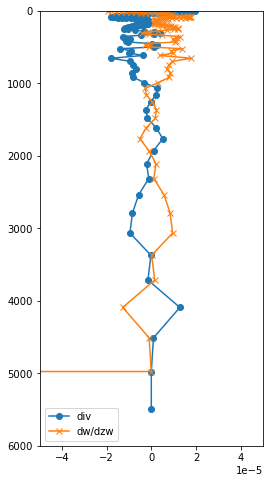

In [107]:
# vertical positiv
C = ddiv.div_v.isel(cc=ic)
ww = dw.w.isel(vert_velocity=ic)
ww =ww.data
wneu = (ww[:-1]-ww[1:])/dzw
ylim = [6000,0]
fig, ax = plt.subplots(figsize=(4,8))
ax.plot(C, depthc, marker="o", label="div")
ax.plot(wneu, depthc, marker="x", label="dw/dzw")
ax.set_ylim(ylim)
ax.set_xlim([-0.00005,0.00005])
ax.legend()

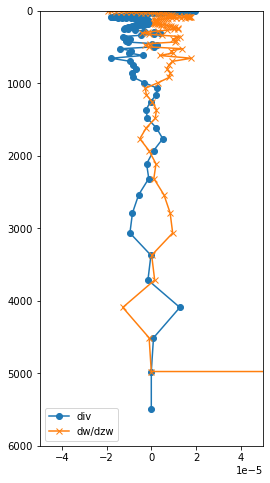

In [184]:
# vertical negative
C = ddiv.div_v.isel(cc=ic)
ww = dw.w.isel(vert_velocity=ic)
ww =ww.data
wneu = (ww[:-1]+ww[1:])/dzw
ylim = [6000,0]
fig, ax = plt.subplots(figsize=(4,8))
ax.plot(C, depthc, marker="o", label="div")
ax.plot(wneu, depthc, marker="x", label="dw/dzw")
ax.set_ylim(ylim)
ax.set_xlim([-0.00005,0.00005])
ax.legend()

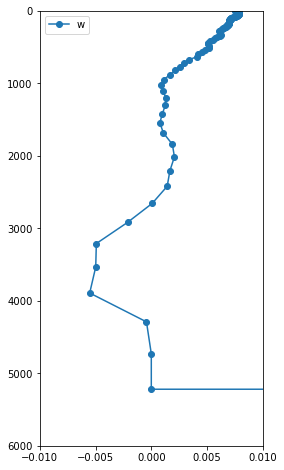

In [130]:
ylim = [6000,0]
fig, ax = plt.subplots(figsize=(4,8))
ax.plot(ww, depthi, marker="o", label="w")
#ax.plot(wneu, depthc, marker="x", label="dw/dzw")
ax.set_ylim(ylim)
ax.set_xlim([-0.01,0.01])
ax.legend()

toi.min() -0.76011163
toi.max() 0.9033878


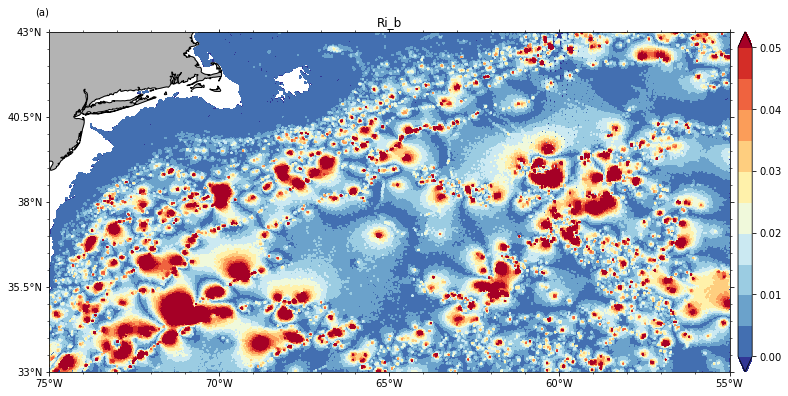

In [167]:
ccrs_proj = ccrs.PlateCarree()
A = dw.w.isel(depthi=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_reg
lat_reg_2 = lat_reg
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False,  clim=(0,0.05), contfs=True)
ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

In [176]:
ccrs_proj = ccrs.PlateCarree()
A = dw.w.isel(depthi=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_regm
lat_reg_2 = lat_regm
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='seismic', clim=-0.05)
ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

toi.min() -0.64348775
toi.max() 0.3261032


In [15]:
## divergence new
ccrs_proj = ccrs.PlateCarree()
A = ddiv.w.isel(depthc=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_reg
lat_reg_2 = lat_reg
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu', clim=1e-4)
ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

toi.min() -0.00348627
toi.max() 0.0016479412


toi.min() -0.0004681371
toi.max() 0.0002714789


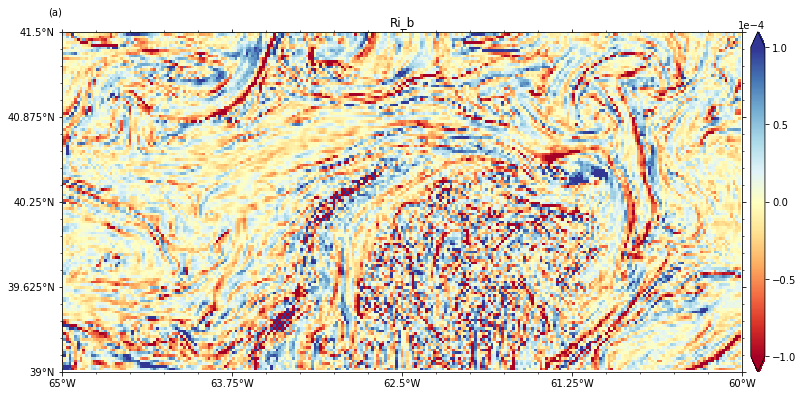

In [16]:
## divergence new
ccrs_proj = ccrs.PlateCarree()
A = ddiv.w.isel(depthc=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_regm
lat_reg_2 = lat_regm
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu', clim=1e-4)
ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

toi.min() -8.0735525e-05
toi.max() 6.367138e-05


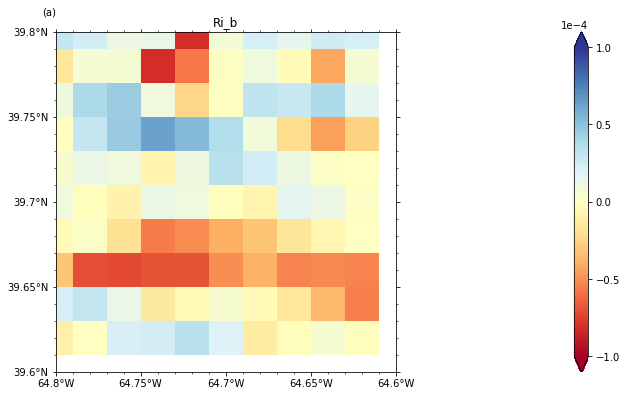

In [17]:
## divergence new
ccrs_proj = ccrs.PlateCarree()
A = ddiv.w.isel(depthc=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_regs
lat_reg_2 = lat_regs
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu', clim=1e-4)
ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

toi.min() -11.3526325
toi.max() 30.007341


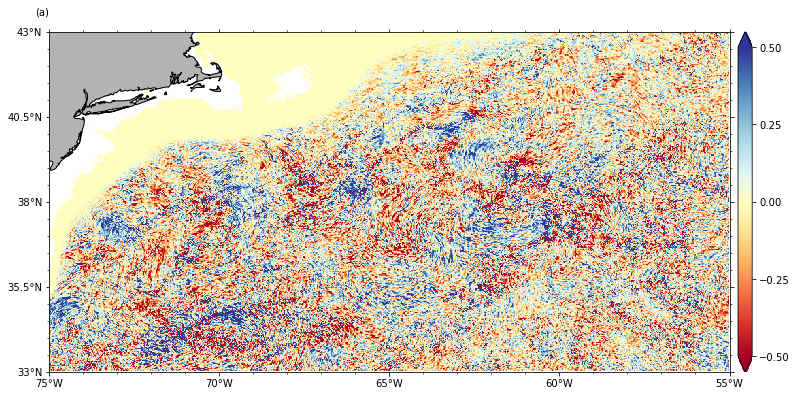

In [41]:
## vertical velo new
ccrs_proj = ccrs.PlateCarree()
A = ds.w.isel(depthi=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_reg
lat_reg_2 = lat_reg
#lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu', clim =0.5)
#ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

toi.min() -59.03943
toi.max() 56.599895


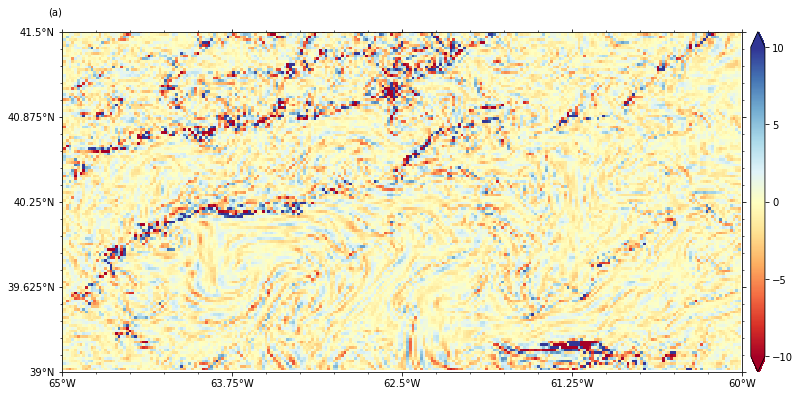

In [33]:
##  vertical velo new
ccrs_proj = ccrs.PlateCarree()
A = ds.w.isel(depthi=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_regm
lat_reg_2 = lat_regm
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu', clim=10)
#ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

In [42]:
##  vertical velo new
ccrs_proj = ccrs.PlateCarree()
A = ds.w.isel(depthi=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_regm
lat_reg_2 = lat_regm
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu', clim=0.5)
#ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

toi.min() -4.1371446
toi.max() 6.967105


In [46]:
##  vertical velo new
ccrs_proj = ccrs.PlateCarree()
A = ds.w.isel(depthi=14)
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj)

lon_reg_2 = lon_regs
lat_reg_2 = lat_regs
lon, lat, toi = pyic.interp_to_rectgrid(A, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)
print('toi.min()', toi.min()); print('toi.max()', toi.max())  
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu', clim=1.5)
#ax.set_title('Ri_b')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

toi.min() -2.126162
toi.max() 2.9181783


In [56]:
from timezonefinder import TimezoneFinder
lon1 = [-70, -60]
lat1 = [32, 37]

tf = TimezoneFinder()
latitude, longitude = lon1[0]-(lon1[0]-lon1[1])/2, lat1[0]-(lat1[0]-lat1[1])/2
timezone = tf.timezone_at(lng=longitude, lat=latitude)
print('latitude', latitude, 'longitudte', longitude, 'timezone', timezone)
#timezone = 'qw 12 da'

latitude -65.0 longitudte 34.5 timezone Etc/GMT-2


In [57]:
numbers = [int(word) for word in timezone.split() if word.isdigit()]

In [58]:
numbers

[]

In [59]:
import re

In [61]:
TZ = -int(re.search(r'\d+', timezone).group())

In [62]:
TZ

-2

In [63]:
ddiv

<xarray.Dataset>
Dimensions:  (cc: 59799625, depthc: 112)
Coordinates:
  * depthc   (depthc) float32 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: cc
Data variables:
    w        (depthc, cc) float32 0.0002017 0.0001932 0.0001154 ... 0.0 0.0 0.0